In [1]:
import time
import numpy as np
import mujoco, mujoco_viewer
import mediapy as media

from scipy.optimize import minimize

from policy_infer import RealtimeController
from utils import quaternion_to_euler_array
from configs import env_cfg, cfg

In [2]:
def load_model_and_data(model_path):
    """
    加载MuJoCo模型和数据
    """
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)
    return model, data

model, data = load_model_and_data(cfg.sim_config.mujoco_model_path)

In [28]:
# 列出所有 Body 名称
print("Bodies:")
for i in range(model.nbody):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_BODY, i)
    print(f"Body ID: {i}, Name: {name}")

# 列出所有 Joint 名称
print("\nJoints:")
for j in range(model.njnt):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, j)
    print(f"Joint ID: {j}, Name: {name}")

# 列出所有 Actuator 名称
print("\nActuators:")
for a in range(model.nu):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, a)
    print(f"Actuator ID: {a}, Name: {name}")

Bodies:
Body ID: 0, Name: world
Body ID: 1, Name: x1-body
Body ID: 2, Name: body_yaw
Body ID: 3, Name: body_roll
Body ID: 4, Name: body_pitch
Body ID: 5, Name: left_shoulder_pitch_link
Body ID: 6, Name: left_shoulder_roll_link
Body ID: 7, Name: left_shoulder_yaw_link
Body ID: 8, Name: left_elbow_pitch_link
Body ID: 9, Name: left_elbow_yaw_link
Body ID: 10, Name: left_wrist_pitch_link
Body ID: 11, Name: left_wrist_roll_link
Body ID: 12, Name: right_shoulder_pitch_link
Body ID: 13, Name: right_shoulder_roll_link
Body ID: 14, Name: right_shoulder_yaw_link
Body ID: 15, Name: right_elbow_pitch_link
Body ID: 16, Name: right_elbow_yaw_link
Body ID: 17, Name: right_wrist_pitch_link
Body ID: 18, Name: right_wrist_roll_link
Body ID: 19, Name: left_hip_pitch_link
Body ID: 20, Name: left_hip_roll_link
Body ID: 21, Name: left_hip_yaw_link
Body ID: 22, Name: left_knee_pitch_link
Body ID: 23, Name: left_ankle_pitch_link
Body ID: 24, Name: left_ankle_roll_link
Body ID: 25, Name: right_hip_pitch_link
B

In [4]:
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()

# 设置相机的默认参数
mujoco.mjv_defaultFreeCamera(model, camera)

# 设置相机位置和目标点
camera.lookat[:] = [0, 0, 1]  # 设置相机观察的目标点 (x, y, z)
camera.distance = 2           # 设置相机到目标点的距离 d
camera.elevation = -10        # 垂直角度（向上或向下）
camera.azimuth = 135          # 水平角度（绕目标点旋转）

In [5]:
mujoco.mj_forward(model, data)
data.body('right_wrist_roll_link').xpos

array([ 0.00233663, -0.19899706,  0.79393384])

In [6]:
# 设置机器人的目标关节位置
pi = np.pi
data.qpos = [ 1.7090e-01, -2.5708e-02,  4.2477e-01,  1.6632e+00,  2.9742e-01,
        -4.6103e-03,  5.7277e-04, -1.6490e-01,  2.5800e-02, -4.2446e-01,
        -1.7049e+00, -2.9865e-01,  8.3074e-03,  3.0371e-03]

# 保存目标关节位置
qpos_target = data.qpos.copy()

# 执行正向动力学计算，更新派生量（但不推进时间）
mujoco.mj_forward(model, data)

# 获取末端执行器的笛卡尔坐标位置
target = data.body('right_wrist_roll_link').xpos
print("Target =>", target)

Target => [ 0.24941365 -0.09848542  1.12280752]


In [7]:
# 重置仿真到关键帧 1，并获取初始状态的末端执行器位置
mujoco.mj_resetDataKeyframe(model, data, 1)  # 重置仿真数据到关键帧 1
mujoco.mj_forward(model, data)  # 更新派生量（但不推进时间）
qpos0 = data.qpos.copy()

In [8]:
# 获取初始位置并渲染场景
init_point = data.body('right_wrist_roll_link').xpos.copy()  # 获取初始点
renderer.update_scene(data, camera)  # 更新渲染场景
init_plot = renderer.render()  # 渲染初始状态图像

# 恢复目标关节配置，计算结果点并渲染场景
data.qpos = qpos_target  # 恢复关节配置
mujoco.mj_forward(model, data)  # 更新派生量
result_point = data.body('right_wrist_roll_link').xpos.copy()  # 获取结果点
renderer.update_scene(data, camera)  # 更新渲染场景
result_plot = renderer.render()  # 渲染结果状态图像

# 打印初始点和目标点的位置
print("Initial point =>", init_point)
print("Desired point =>", result_point, "\n")

Initial point => [ 0.00233663 -0.19899706  0.79393384]
Desired point => [ 0.24941365 -0.09848542  1.12280752] 



In [9]:
qpos_test = qpos0.copy()
qpos_test[1] = -1
data.qpos = qpos_test
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
test_plot = renderer.render()

Initial position,Desired end effector position,Test position

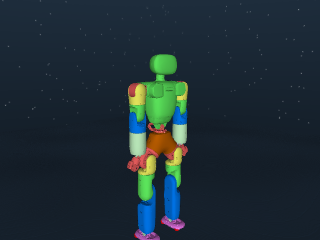
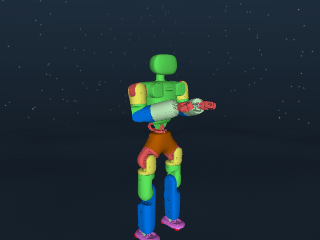
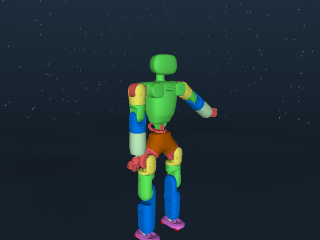

In [10]:
# 可视化结果
images = {
    'Initial position': init_plot,          # 初始位置图像
    'Desired end effector position': result_plot,  # 目标位置图像
    'Test position': test_plot
}

media.show_images(images)  # 显示图像

In [12]:
# Gradient Descent method
class GradientDescentIK:
    
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
    
    def check_joint_limits(self, q):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], 
                       min(q[i], self.model.jnt_range[i][1]))

    #Gradient Descent pseudocode implementation
    def calculate(self, goal, init_q, body_id):
        """Calculate the desire joints angles for goal"""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)

        while (np.linalg.norm(error) >= self.tol):
            #calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, 
                          self.jacr, goal, body_id)
            #calculate gradient
            grad = self.alpha * self.jacp.T @ error
            #compute next step
            self.data.qpos += self.step_size * grad
            #check joint limits
            self.check_joint_limits(self.data.qpos)
            #compute forward kinematics
            mujoco.mj_forward(self.model, self.data) 
            #calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)


Results
testing point => [ 0.00233663 -0.19899706  0.79393384]
Gradient Descent result => [0.30865207 0.1014768  0.99522976] 



Testing point,Gradient Descent result

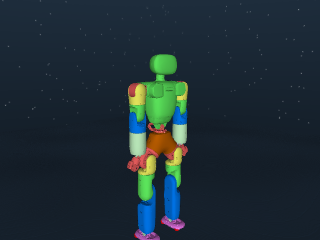
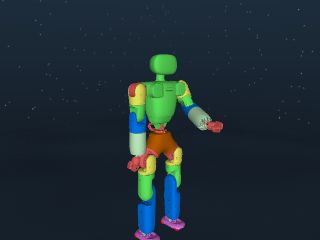

In [15]:
#Init variables.
body_id = model.body('left_wrist_roll_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [0.3000, 0.1000, 1.0]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0] * model.nq

ik = GradientDescentIK(model, data, step_size, tol, alpha, jacp, jacr)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, body_id) #calculate the q angles

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('left_wrist_roll_link').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("testing point =>", target)
print("Gradient Descent result =>", result_point, "\n")

images = {
    'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)